In [1]:
import torch
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
import torchvision.datasets as dsets
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from  torchvision import transforms
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda') # Uncomment this to run on GPU

In [7]:
T = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize((0.1307,), (0.3081,))                   
])

train_data = dsets.MNIST(root = "./", train = True, download = True, transform = T)
val_data = dsets.MNIST(root = "./", train = False, download = True,transform = T)

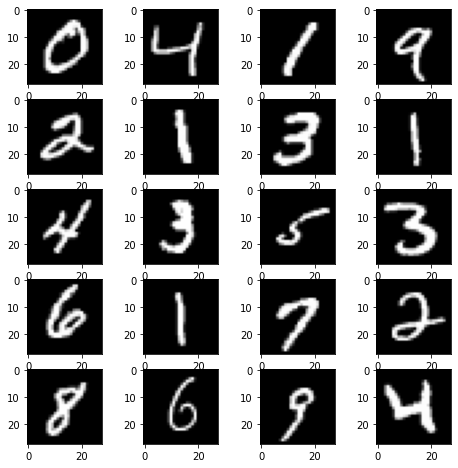

In [8]:
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(train_data[i][0].squeeze(), cmap = "gray")
plt.show()

In [9]:
train_loader = DataLoader(train_data, batch_size= 64)
val_loader = DataLoader(val_data, batch_size= 64)

In [58]:
class LeNet(nn.Module):
  def __init__(self) -> None:
      super().__init__()

      self.conv1 = nn.Conv2d(in_channels= 1, out_channels=6, kernel_size=(5,5),stride = 1 , padding="same")
      self.avg_pool1 = nn.AvgPool2d(kernel_size=(2,2), stride=(2,2))

      self.conv2 = nn.Conv2d(in_channels= 6, out_channels=16, kernel_size=(5,5), stride = 1)
      self.avg_pool2 = nn.AvgPool2d(kernel_size=(2,2),stride=(2,2))

      self.conv3 = nn.Conv2d(in_channels= 16, out_channels=120, kernel_size=(5,5), stride = 1)
      
      self.flatten = nn.Flatten()
      self.linear1 = nn.Linear(120,84)
      self.linear2 = nn.Linear(84,10)

  def forward(self,x):
    x = torch.tanh(self.conv1(x))
    x = self.avg_pool1(x)
    x = torch.tanh(self.conv2(x))
    x = self.avg_pool2(x)
    x = torch.tanh(self.conv3(x))
    #x = self.flatten(x,1)
    x = x.reshape(x.shape[0], -1)
    x = torch.tanh(self.linear1(x))
    x = F.softmax(self.linear2(x))
    
    return x

In [59]:
model = LeNet().cuda()
summary(model, input_size = (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
         AvgPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         AvgPool2d-4             [-1, 16, 5, 5]               0
            Conv2d-5            [-1, 120, 1, 1]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
epochs = 10

In [60]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    correct = 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    return loss.cpu().detach().numpy() , correct/size


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y  = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct

def train(model,loss, optimizer, train_loader, val_loader,epochs):
  history = {"train_loss":[], "val_loss": [], "train_acc":[], "val_acc":[]}
  
  for t in range(epochs): 
    print(f"Epoch {t+1}\n-------------------------------")

    train_loss, train_acc = train_loop(train_loader, model, loss_fn, optimizer)
    history["train_loss"].append(train_loss),history["train_acc"].append(train_acc)
    
    val_loss, val_acc = test_loop(val_loader, model, loss_fn)
    history["val_loss"].append(val_loss),history["val_acc"].append(val_acc)

  print("Done!")  
  
  return history


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

epochs = 10
history = train(model,loss_fn, optimizer, train_loader, val_loader,epochs)

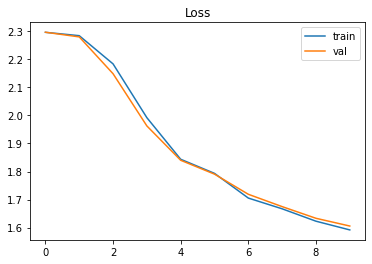

In [64]:
plt.plot(history["train_loss"],label = "train")
plt.plot(history["val_loss"],label = "val")
plt.legend(loc="upper right")
plt.title("Loss")
plt.show()

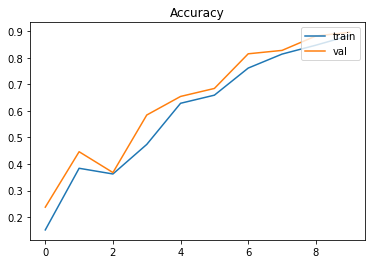

In [65]:
plt.plot(history["train_acc"],label = "train")
plt.plot(history["val_acc"],label = "val")
plt.legend(loc="upper right")
plt.title("Accuracy")
plt.show()